In [1]:
import glob
import copy
from collections import OrderedDict
import itertools
import os, sys
from pprint import pprint
import time
import pickle
import shutil

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as dists
import random

from numpy.polynomial import legendre

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from torch.cuda import is_available as cuda_available

cuda_available()

torch.set_default_tensor_type(torch.DoubleTensor)

def to_np(v):
    if type(v) == float:
        return v

    if v.is_cuda:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

def get_coverage_bounds(posterior_pred_samples, percentile):
    """
    Assumes N x samples
    """
    assert not (percentile < 0.0 or percentile > 100.0)

    lower_percentile = (100.0 - percentile) / 2.0
    upper_percentile = 100.0 - lower_percentile

    upper_bounds = np.percentile(posterior_pred_samples, upper_percentile, axis=-1)
    lower_bounds = np.percentile(posterior_pred_samples, lower_percentile, axis=-1)

    return lower_bounds, upper_bounds


def cubic(x):
    return torch.pow(x, 3.0)

def sine(x):
    return torch.sin(x)

def xsinx(x):
    return torch.multiply(x, torch.sin(x))

def add_output_noise(r, output_var):
    """
    Adds Gaussian noise to a tensor
    """
    eps = torch.nn.init.normal_(torch.zeros_like(r), std=math.sqrt(output_var))
    assert eps.size() == r.size()
    return r + eps

def generate_data(teacher, train_dataset_size, dataset_min_range = -1, dataset_max_range = 1, gap_min_range = -0.5, gap_max_range = 0.5, output_var = 0.01, random_seed=0, test=False):
    '''
    Generates data according to hyperparameters specified
    '''
    # dataset parameters
    N = train_dataset_size
    var = output_var

    if not test:
        # set random seed for reproducibility
        torch.manual_seed(random_seed)
        random.seed(random_seed)
        np.random.seed(random_seed)

        x = torch.cat(
                (dists.Uniform(dataset_min_range, gap_min_range).sample((N//2, 1)),
                 dists.Uniform(gap_max_range, dataset_max_range).sample((N//2, 1)))
            )
        x = torch.sort(x, axis=0)[0]
        y = add_output_noise(teacher(x), var)

    else:
        # TODO: how do we wanna do test data?
        pass

    return x, y


In [2]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel
import warnings

class BayesianRegression(nn.Module):
    def __init__(self, w_prior_var = 1., output_var = 0.1):
        super(BayesianRegression, self).__init__()

        self.weights_var = w_prior_var
        self.output_var = output_var

        self.posterior = None
        self.posterior_mu = None
        self.posterior_cov = None

    def data_to_features(self, x):
        """
        Concatenate features x with a column of 1s (for bias)
        """

        ones = torch.ones(x.shape[0], 1)
        if cuda_available():
            ones = ones.cuda()

        return torch.cat([x, ones], -1)

    def get_posterior(self):
        return self.posterior

    def bayesian_linear_regression_posterior_1d(self, X, y):
        # See this link for derivation: http://cs229.stanford.edu/section/cs229-gaussian_processes.pdf
        # prior is distributed N(0, weights_var^2)
        # output y is distributed N(wx, output_var^2)
        assert len(X.shape) == 2
        assert len(y.shape) == 2
        assert y.shape[-1] == 1

        eye = torch.eye(X.shape[-1])
        if cuda_available():
            eye = eye.cuda()

        posterior_precision = (
            eye / self.weights_var + torch.mm(X.t(), X) / self.output_var
        )
        posterior_cov = torch.pinverse(posterior_precision)
        posterior_mu = (
            torch.mm(posterior_cov, torch.mm(X.t(), y)).squeeze() / self.output_var
        )

        return (
            dists.MultivariateNormal(
                posterior_mu, precision_matrix=posterior_precision
            ),
            posterior_mu,
            posterior_cov,
        )

    def infer_posterior(self, x, y):
        """
        Infers posterior and stores it within the class instance
        """

        phi = self.data_to_features(x)
        assert len(phi.shape) == 2

        (
            self.posterior,
            self.posterior_mu,
            self.posterior_cov,
        ) = self.bayesian_linear_regression_posterior_1d(phi, y)

        return self.posterior

    def sample_posterior_predictive(self, x, num_samples, add_noise=True):
        # assert(self.posterior is not None)
        # if there was no training, just sample from prior
        if self.posterior == None:
            return self.sample_prior_predictive(x, num_samples, add_noise=add_noise)

        phi = self.data_to_features(x)

        weights = self.posterior.rsample(torch.Size([num_samples]))
        assert weights.shape == (num_samples, phi.shape[-1])

        r = torch.mm(phi, weights.t())
        assert r.shape == torch.Size([x.shape[0], num_samples])

        if add_noise:
            return add_output_noise(r, self.output_var)
        else:
            return r

    def sample_prior_predictive(self, x, num_samples, add_noise=True):
        phi = self.data_to_features(x)

        weights = dists.Normal(0.0, math.sqrt(self.weights_var)).sample(
            (num_samples, phi.shape[-1])
        )
        assert len(weights.shape) == 2

        r = torch.mm(phi, weights.t())
        assert r.shape == torch.Size([x.shape[0], num_samples])

        if add_noise:
            return add_output_noise(r, self.output_var)
        return r

    # define MLL loss
    def marginal_log_likelihood(self, alpha, beta, x, y):
        """
        Log likelihood of the data marginalised over the weights w. See chapter 3.5 of
        the book by Bishop of an derivation.
        Parameters
        ---------
        x, y: input datapoints and corresponding y values. x is of dimension N x D
        alpha: variance prior on weights
        beta: output variance on y

        Returns
        -------
        float
            lnlikelihood + prior
        """

        # alpha = self.hyp["w_prior_var"]
        # beta = self.hyp["output_var"]

        # dimensionality of input datapoint
        D = x.shape[1]
        N = x.shape[0]

        # TODO: currently x is basis(x_train)
        # can add if using a basis function then do a transformation first

        Theta = to_np(x)

        K = beta * np.dot(Theta.T, Theta)
        K += np.eye(Theta.shape[1]) * alpha
        try:
            K_inv = np.linalg.inv(K)
        except np.linalg.linalg.LinAlgError:
            K_inv = np.linalg.inv(K + np.random.rand(K.shape[0], K.shape[1]) * 1e-8)

        m = beta * np.dot(K_inv, Theta.T)
        m = np.dot(m, y)

        mll = D / 2 * np.log(alpha)
        mll += N / 2 * np.log(beta)
        mll -= N / 2 * np.log(2 * np.pi)
        mll -= beta / 2.0 * np.linalg.norm(y - np.dot(Theta, m), 2)
        mll -= alpha / 2.0 * np.dot(m.T, m)
        mll -= 0.5 * np.log(np.linalg.det(K) + 1e-10)

        return mll.squeeze()

    def negative_marginal_log_likelihood(self, alpha, beta, x, y):
        return -self.marginal_log_likelihood(alpha, beta, x, y)

    def posterior_contraction(self):
        return torch.sum(1 - torch.diag(self.posterior_cov)).detach().cpu().numpy()
        
    def visualize_posterior_predictive(self, x_viz, phi, x_train, y_train, savefig=None):
        y_pred = self.sample_posterior_predictive(phi, 1000)
        
        # make sure x_viz is sorted in ascending order
        x_viz = to_np(x_viz.squeeze())
        assert np.all(x_viz[:-1] <= x_viz[1:])

        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

        # plot predictive intervals
        for picp, alpha in zip([50.0, 68.0, 95.0], [0.4, 0.3, 0.2]):
            lower, upper = get_coverage_bounds(to_np(y_pred), picp)

            ax.fill_between(
                x_viz,
                lower,
                upper,
                label="{}%-PICP".format(picp),
                color="steelblue",
                alpha=alpha,
            )

        # plot predictive mean
        pred_mean = to_np(torch.mean(y_pred, -1))
        ax.plot(x_viz, pred_mean, color="blue", lw=3, label="Predictive Mean")

        # plot training data
        ax.scatter(
            x_train, y_train, color="red", s=10.0, zorder=10, label="Training Data"
        )

        ax.set_xlabel("$x$")
        ax.set_ylabel("$y$")
        ax.set_title("Posterior Predictive")
        ax.legend()
        plt.show()

In [4]:
def create_fourier_basis(num_bases, omega_scale=1.0):
    # source:
    # https://gregorygundersen.com/blog/2019/12/23/random-fourier-features/#kimeldorf1971some
    omegas = np.random.normal(loc=0, scale=omega_scale, size=num_bases)
    bs = np.random.uniform(low=0.0, high=np.pi*2, size=num_bases)
    # a = 1/np.sqrt(np.sqrt(2 * np.pi) / omega_scale)
    a = 1
    def random_fourier_basis(x):
        basis_vals = np.zeros((len(x), num_bases))
        for i in range(num_bases):
            basis_vals[:,i] = np.sqrt(2)/(np.sqrt(num_bases)) * a * np.cos(omegas[i] * x.flatten() + bs[i])
        return torch.tensor(basis_vals)
    return random_fourier_basis

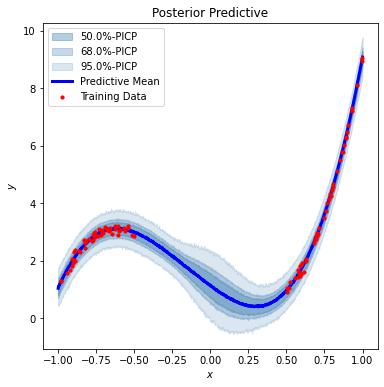

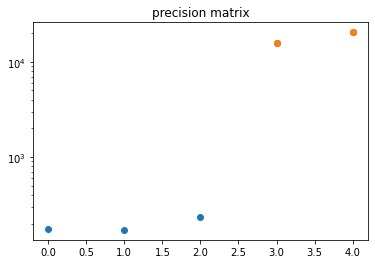

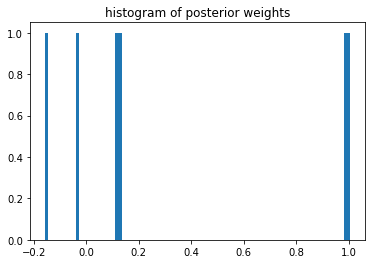

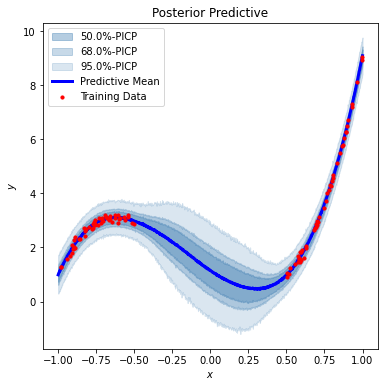

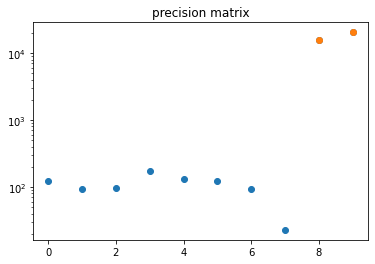

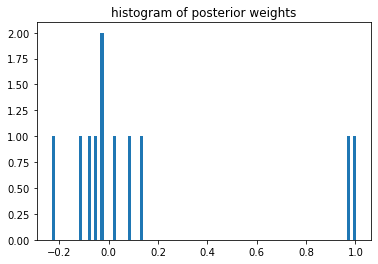

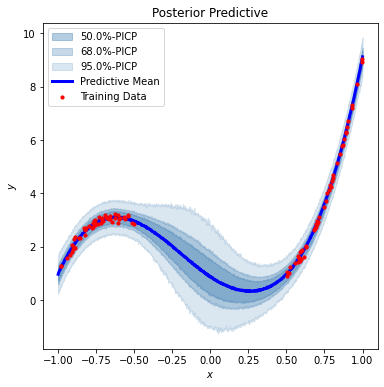

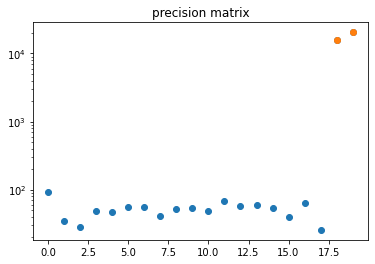

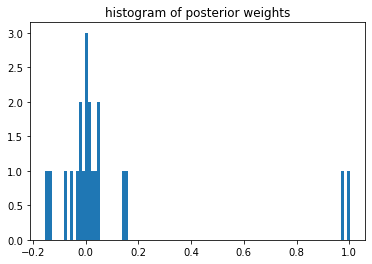

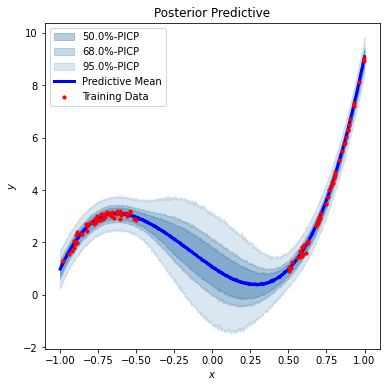

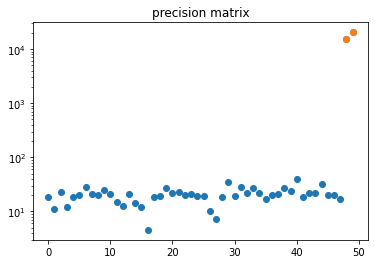

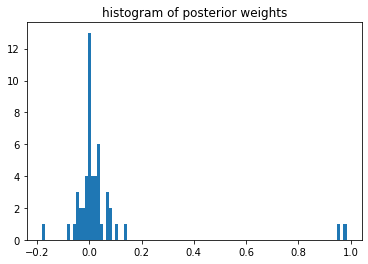

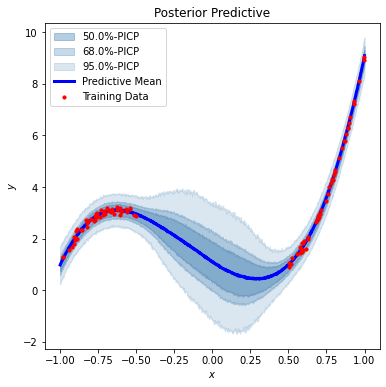

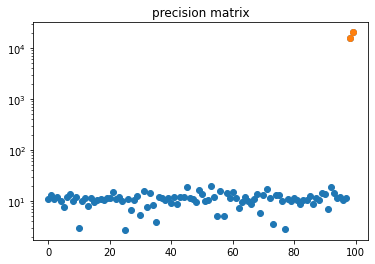

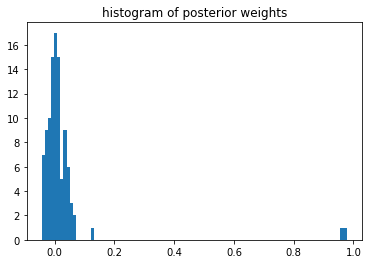

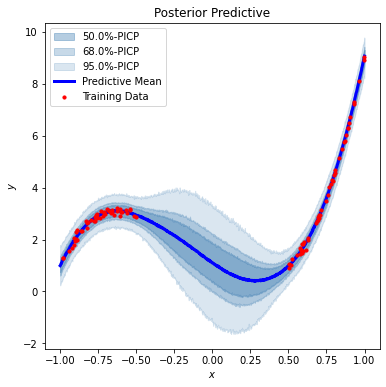

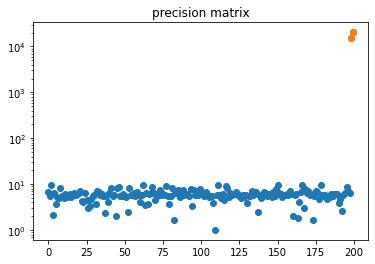

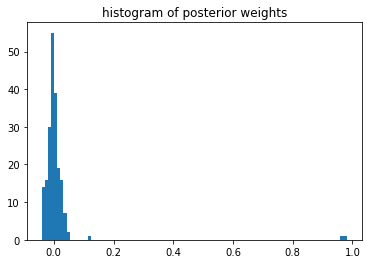

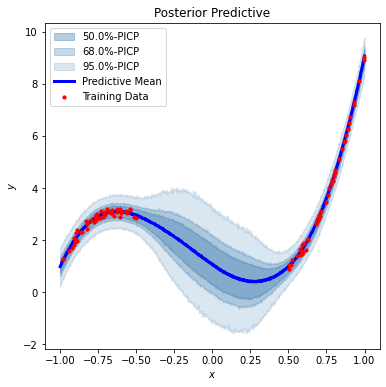

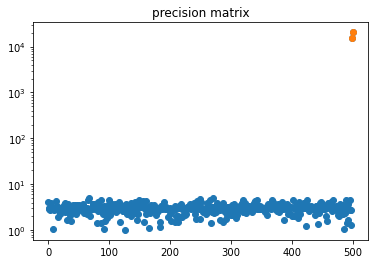

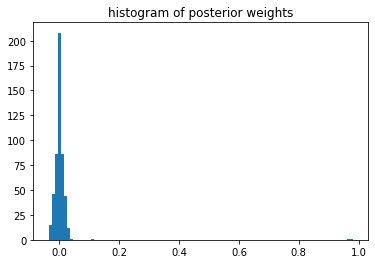

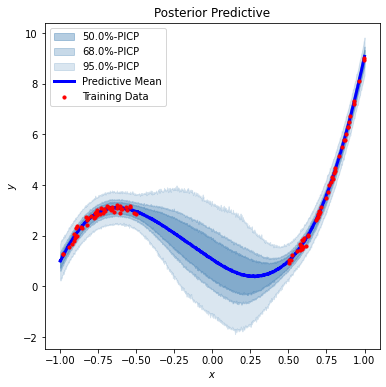

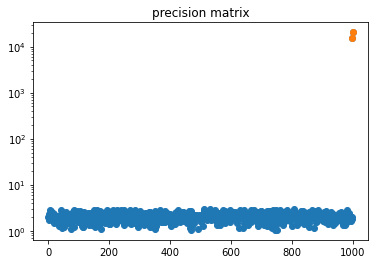

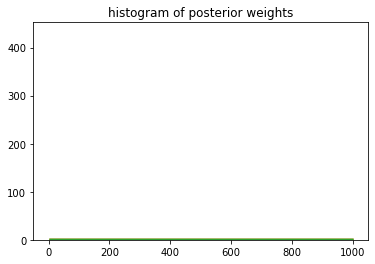

In [5]:
teacher_1 = lambda x: (2*x)**3
teacher_2 = lambda x: (2*x-1)**2
teacher = lambda x: teacher_1(x) + teacher_2(x)
num_bases = 100

x, y = generate_data(teacher, 100, dataset_min_range=-1, dataset_max_range=1, gap_min_range=-0.5, gap_max_range=0.5)

posterior_of_teacher = []
true_bases = True

for num_bases in [5, 10, 20, 50, 100, 200, 500, 1000]:
    rff_basis = create_fourier_basis(num_bases, omega_scale=5)
    phi = rff_basis(x) 

    if true_bases:
        phi[:,-2] = teacher_1(x).squeeze()
        phi[:,-1] = teacher_2(x).squeeze()

    blm = BayesianRegression(w_prior_var=1, output_var=.1)
    blm.infer_posterior(phi, y).loc 
    # self.basis(x_train), y_train in the codebase 

    x_viz = torch.linspace(-1, 1, 1000)
    phi_t = rff_basis(x_viz)
    if true_bases:
        phi_t[:,-2] = teacher_1(x_viz).squeeze()
        phi_t[:,-1] = teacher_2(x_viz).squeeze()


    blm.visualize_posterior_predictive(x_viz, phi_t, x, y)
    posterior_of_teacher.append(blm.posterior.loc[-3:-1].numpy())
    plt.plot(np.arange(0, num_bases), np.diag(blm.posterior.precision_matrix)[:-1], 'o')
    if true_bases:
        plt.plot(np.arange(num_bases-2, num_bases), np.diag(blm.posterior.precision_matrix)[-3:-1], 'o')
        plt.title("precision matrix")
    plt.yscale('log')
    plt.show()
    plt.hist(blm.posterior.loc.numpy(), 100)
    plt.title("histogram of posterior weights")

plt.plot([5, 10, 20, 50, 100, 200, 500, 1000], np.array(posterior_of_teacher))


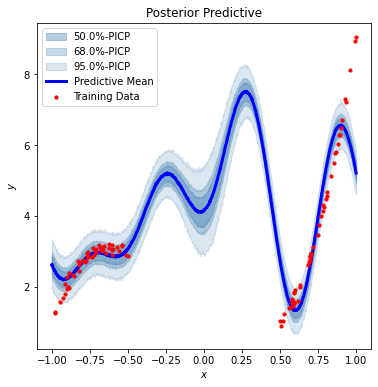

tensor([[ 176.2786,  -23.4835,  159.5597,  -34.5319, -103.4399, -236.1567],
        [ -23.4835,  171.8098,  -60.9370,  -83.4091,   56.1825,   45.9388],
        [ 159.5597,  -60.9370,  235.0693,   15.2429,  -53.5726, -436.1447],
        [ -34.5319,  -83.4091,   15.2429,  205.1880,   -8.5341,   38.6808],
        [-103.4399,   56.1825,  -53.5726,   -8.5341,  201.3999,    7.6737],
        [-236.1567,   45.9388, -436.1447,   38.6808,    7.6737, 1001.0000]]) [176.27861281 171.80983908 235.06926051 205.1879739  201.39986215]


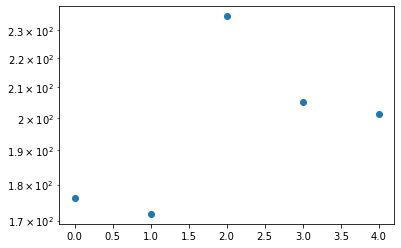

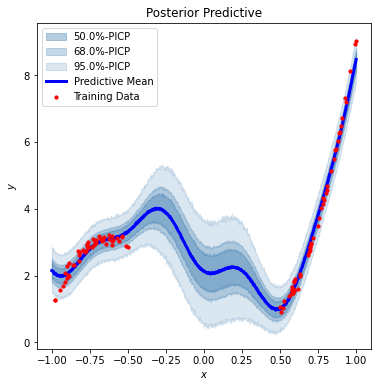

tensor([[ 123.9088,  -33.4672,  -67.8227,  -19.9942,   17.6485,  112.9628,
            8.6326,  -35.5125,   75.7223,  -70.4217, -309.7856],
        [ -33.4672,   94.2159,   16.3612,   12.5405,  -11.0799,  -15.2710,
          -23.9462,    1.4840,  -14.9725,   19.4731,   36.6869],
        [ -67.8227,   16.3612,   96.4511,  -54.1170,   38.4333,  -58.2217,
           11.8551,   41.9455,   -6.3753,   86.1038,  187.6884],
        [ -19.9942,   12.5405,  -54.1170,  173.9937, -148.5791,  -31.9659,
           30.6394,  -24.5217, -102.2938,  -30.6184,    8.0620],
        [  17.6485,  -11.0799,   38.4333, -148.5791,  133.3533,   33.4292,
          -23.8734,   20.3631,   87.7289,   11.9515,  -29.6658],
        [ 112.9628,  -15.2710,  -58.2217,  -31.9659,   33.4292,  120.7574,
           22.7806,  -27.4610,   79.0469,  -75.5506, -336.4459],
        [   8.6326,  -23.9462,   11.8551,   30.6394,  -23.8734,   22.7806,
           93.0091,   13.1041,  -12.0033,  -11.8696, -106.3264],
        [ -35.5125, 

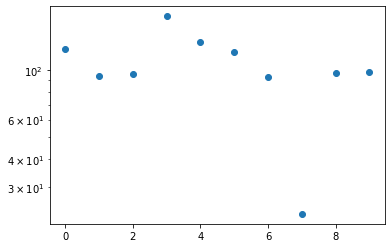

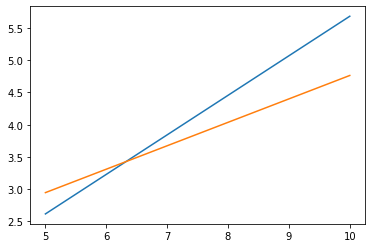

In [10]:
teacher_1 = lambda x: (2*x)**3
teacher_2 = lambda x: (2*x-1)**2
teacher = lambda x: teacher_1(x) + teacher_2(x)
num_bases = 100

x, y = generate_data(teacher, 100, dataset_min_range=-1, dataset_max_range=1, gap_min_range=-0.5, gap_max_range=0.5)

posterior_of_teacher = []
true_bases = False

for num_bases in [5, 10]:
    rff_basis = create_fourier_basis(num_bases, omega_scale=5)
    phi = rff_basis(x)

    if true_bases:
        phi[:,-2] = teacher_1(x).squeeze()
        phi[:,-1] = teacher_2(x).squeeze()

    blm = BayesianRegression(w_prior_var=1, output_var=.1)
    blm.infer_posterior(phi, y).loc

    x_viz = torch.linspace(-1, 1, 1000)
    phi_t = rff_basis(x_viz)
    if true_bases:
        phi_t[:,-2] = teacher_1(x_viz).squeeze()
        phi_t[:,-1] = teacher_2(x_viz).squeeze()


    blm.visualize_posterior_predictive(x_viz, phi_t, x, y)
    posterior_of_teacher.append(blm.posterior.loc[-3:-1].numpy())
    plt.plot(np.arange(0, num_bases), np.diag(blm.posterior.precision_matrix)[:-1], 'o')
    if true_bases:
        plt.plot(np.arange(num_bases-2, num_bases), np.diag(blm.posterior.precision_matrix)[-3:-1], 'o')
    plt.yscale('log')
    plt.show()
    #, 20, 50, 100, 200, 500, 1000

plt.plot([5, 10], np.array(posterior_of_teacher))


### If true function is a weighted sum of two bases, with weights and variances highlighted

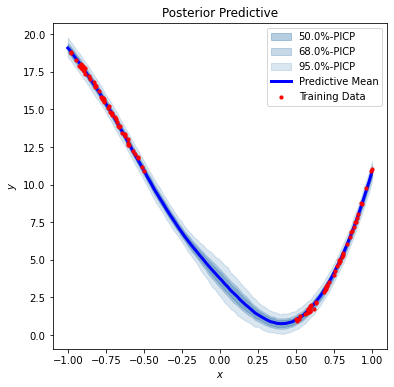

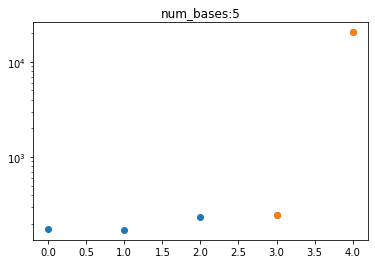

<class 'torch.Tensor'>


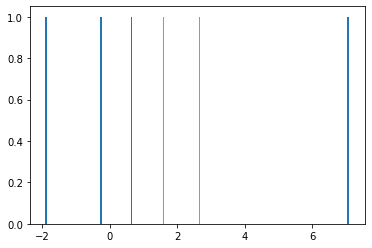

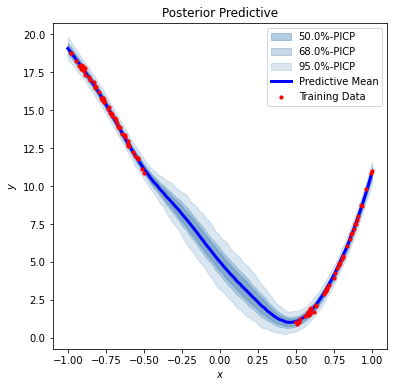

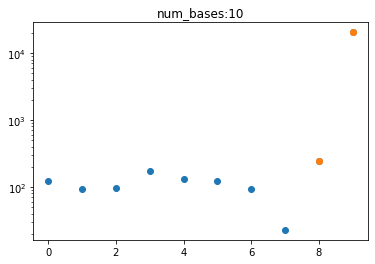

<class 'torch.Tensor'>


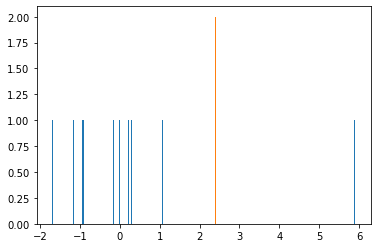

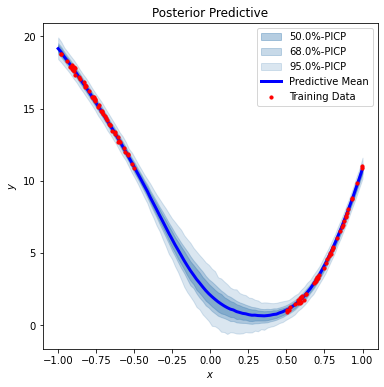

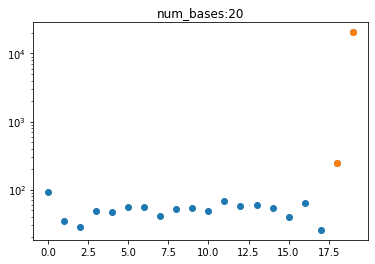

<class 'torch.Tensor'>


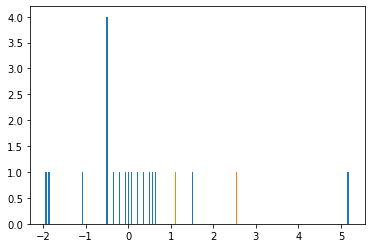

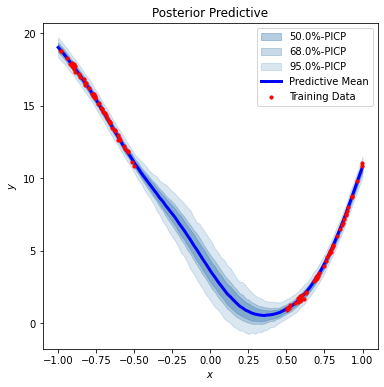

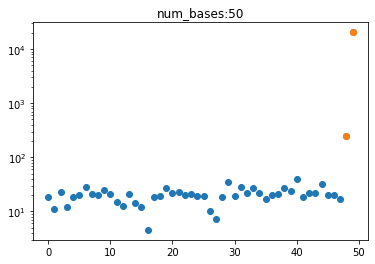

<class 'torch.Tensor'>


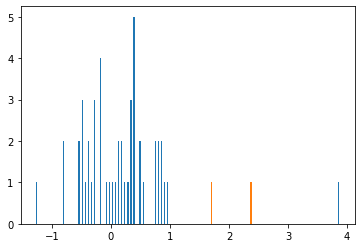

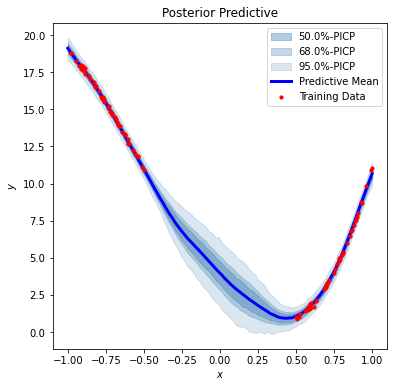

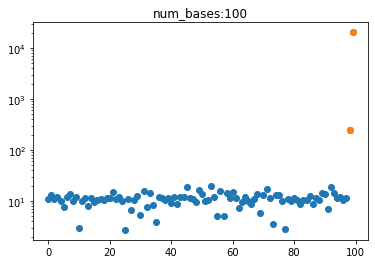

<class 'torch.Tensor'>


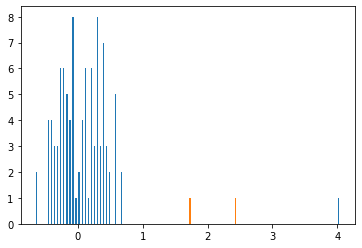

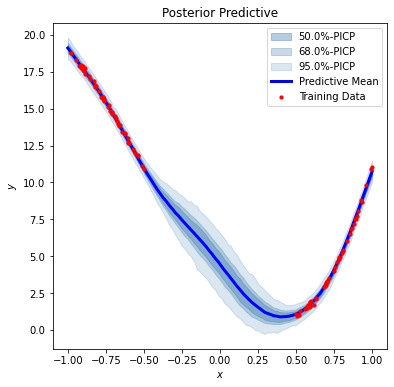

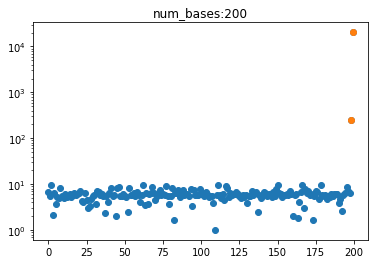

<class 'torch.Tensor'>


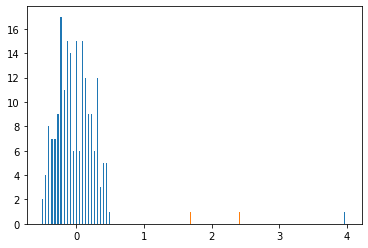

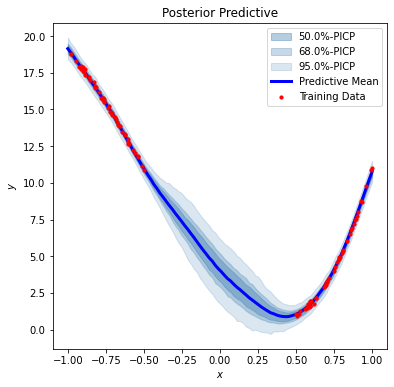

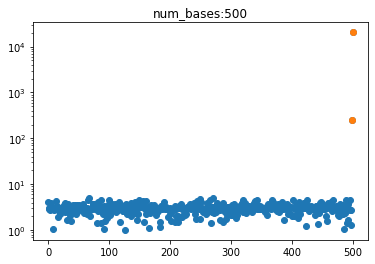

<class 'torch.Tensor'>


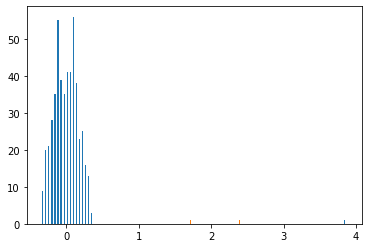

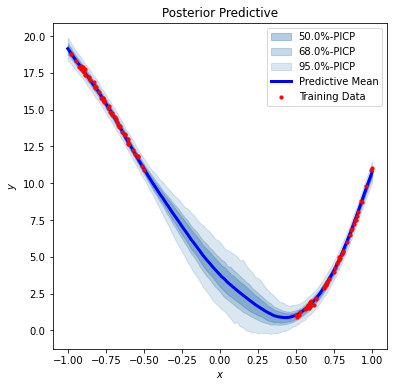

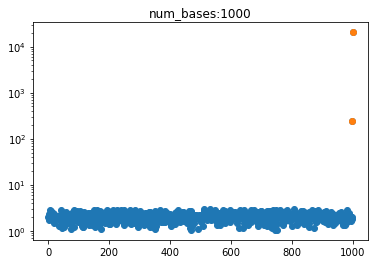

<class 'torch.Tensor'>


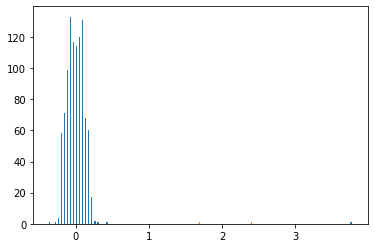

In [32]:
import string
teacher_1 = lambda x: (x)**3
teacher_2 = lambda x: (2*x-1)**2
teacher = lambda x: 8*teacher_1(x) + 3*teacher_2(x) # weighted sum of the two
num_bases = 100

x, y = generate_data(teacher, 100, dataset_min_range=-1, dataset_max_range=1, gap_min_range=-0.5, gap_max_range=0.5)

posterior_of_teacher = []
true_bases = True

for num_bases in [5, 10, 20, 50, 100, 200, 500, 1000]:
    rff_basis = create_fourier_basis(num_bases, omega_scale=5)
    phi = rff_basis(x)

    if true_bases:
        phi[:,-2] = teacher_1(x).squeeze()
        phi[:,-1] = teacher_2(x).squeeze()

    blm = BayesianRegression(w_prior_var=1, output_var=.1)
    blm.infer_posterior(phi, y).loc

    x_viz = torch.linspace(-1, 1, 100)
    phi_t = rff_basis(x_viz)
    if true_bases:
        phi_t[:,-2] = teacher_1(x_viz).squeeze()
        phi_t[:,-1] = teacher_2(x_viz).squeeze()


    blm.visualize_posterior_predictive(x_viz, phi_t, x, y)
    posterior_of_teacher.append(blm.posterior.loc[-3:-1].numpy())
    plt.plot(np.arange(0, num_bases), np.diag(blm.posterior.precision_matrix)[:-1], 'o')
    plt.title("num_bases:{}".format(num_bases))
    if true_bases:
        plt.plot(np.arange(num_bases-2, num_bases), np.diag(blm.posterior.precision_matrix)[-3:-1], 'o')
    plt.yscale('log')
    plt.show()
    print(type(blm.posterior.loc))
   # plt.hist(blm.posterior.loc.numpy(), 100)
    # Figure and set of subplots
    fig, ax = plt.subplots()
    post_multi = [blm.posterior.loc.numpy()[:-2],blm.posterior.loc.numpy()[-2:]]
    ax.hist(post_multi, 100, histtype='bar')

   

#plt.plot([5, 10, 20, 50, 100, 200, 500, 1000], np.array(posterior_of_teacher)[0])


Notice that when it is a weighted sum, the two true bases don't share the same posterior precision anymore.

### 2 teachers continued
#### In the 2 teachers case: For both unweighted and weighted - always low variance but not necessarily high means.

### having more teachers and see if the pattern extends. 

#### This is with 3 teachers, and the weights do not have significantly lower variance than others. Bigger weights in the original basis function does not correspond to higher posterior weights mean.  Note that data fit is bad for fewer bases. (so part of hypothesis 2 is wrong)

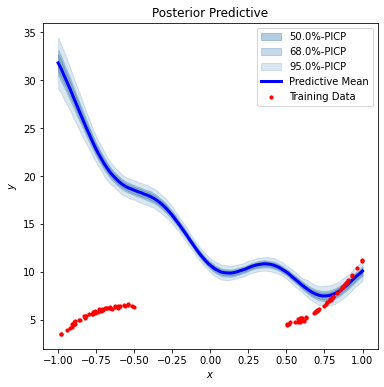

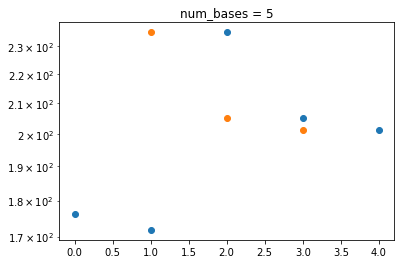

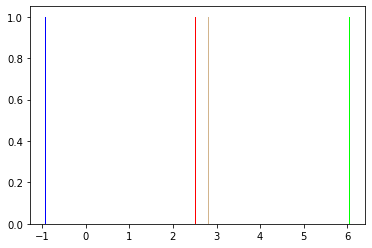

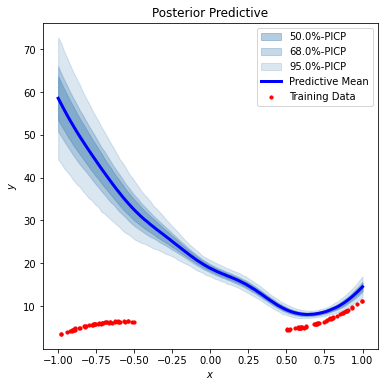

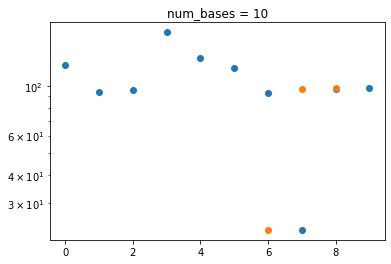

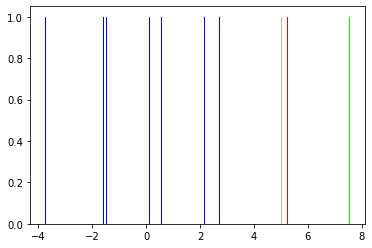

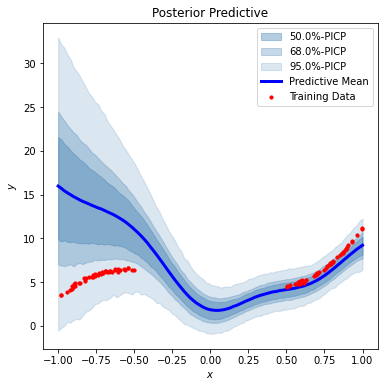

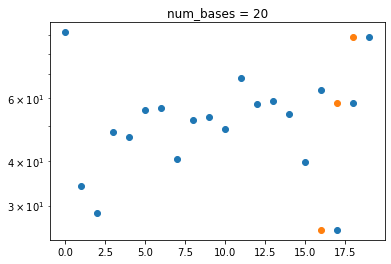

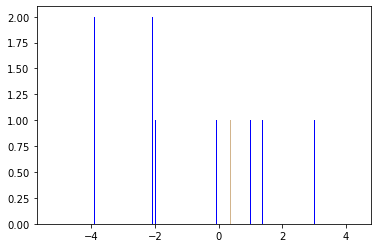

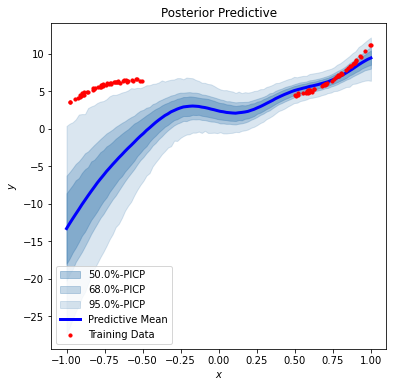

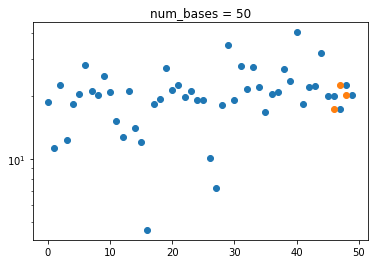

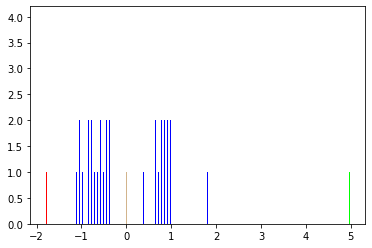

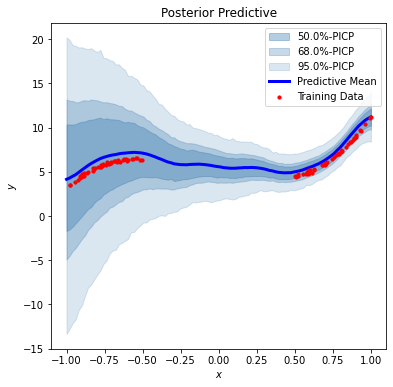

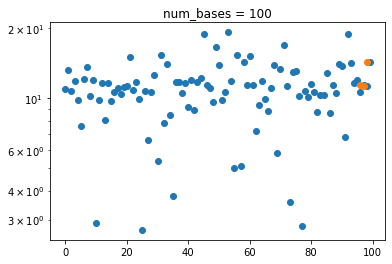

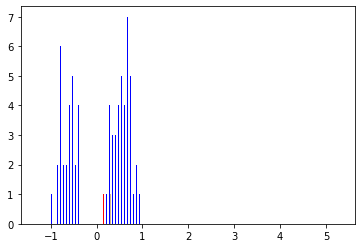

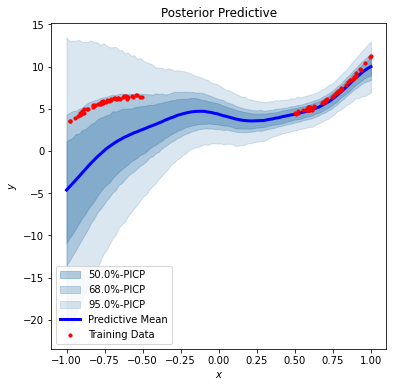

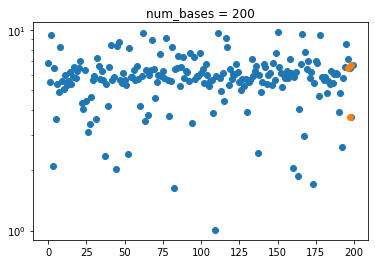

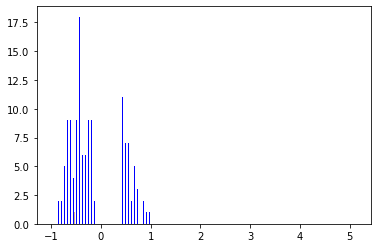

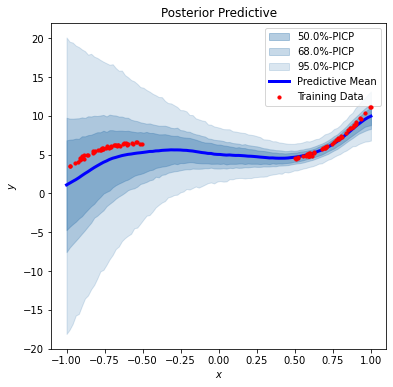

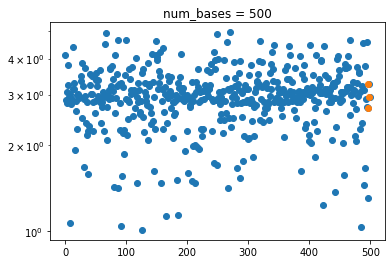

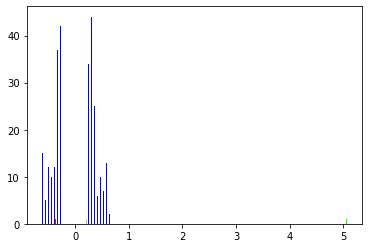

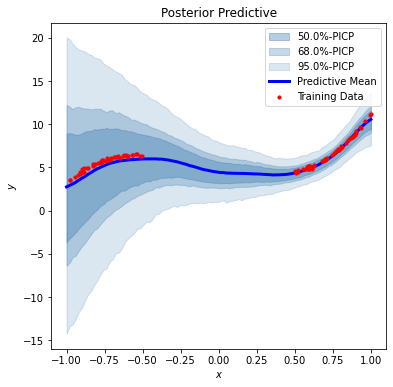

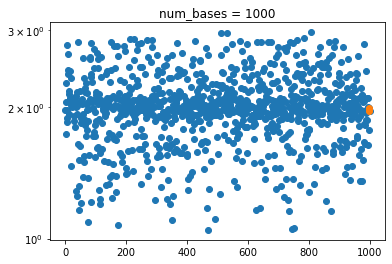

ValueError: x and y must have same first dimension, but have shapes (8,) and (3,)

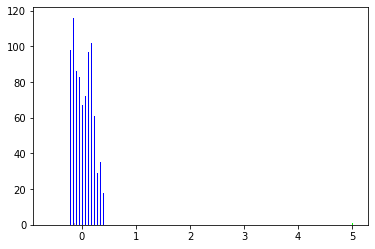

In [29]:
# An example with bad data fit
teacher_1 = lambda x: (x)**3
teacher_2 = lambda x: (2*x-1)**2
teacher_3 = lambda x: np.cos(x) # third cos teacher 
teacher = lambda x: 8*teacher_1(x) + 1*teacher_2(x) + 4*teacher_3(x) # weighted sum of the two
num_bases = 100

x, y = generate_data(teacher, 100, dataset_min_range=-1, dataset_max_range=1, gap_min_range=-0.5, gap_max_range=0.5)

posterior_of_teacher = []
true_bases = True

for num_bases in [5, 10, 20, 50, 100, 200, 500, 1000]:
    rff_basis = create_fourier_basis(num_bases, omega_scale=5)
    phi = rff_basis(x)

    blm = BayesianRegression(w_prior_var=1, output_var=.1)
    blm.infer_posterior(phi, y).loc

    x_viz = torch.linspace(-1, 1, 100)
    phi_t = rff_basis(x_viz)
    if true_bases:
        phi_t[:,-3] = teacher_1(x_viz).squeeze()
        phi_t[:,-2] = teacher_2(x_viz).squeeze()
        phi_t[:,-1] = teacher_3(x_viz).squeeze()

    blm.visualize_posterior_predictive(x_viz, phi_t, x, y)
    posterior_of_teacher.append(blm.posterior.loc[-4:-1].numpy())
    plt.plot(np.arange(0, num_bases), np.diag(blm.posterior.precision_matrix)[:-1], 'o')
    plt.title("num_bases = {}".format(num_bases))
    if true_bases:
        plt.plot(np.arange(num_bases-4, num_bases-1), np.diag(blm.posterior.precision_matrix)[-4:-1], 'o')
    plt.yscale('log')
    plt.show()
    #plt.hist(blm.posterior.loc.numpy(), 100)
    fig, ax = plt.subplots()
    colors = ['blue','red', 'tan', 'lime']
    post_multi = [blm.posterior.loc.numpy()[:-3],blm.posterior.loc.numpy()[-3:-2],blm.posterior.loc.numpy()[-2:-1],blm.posterior.loc.numpy()[-1]]
    ax.hist(post_multi, 100, histtype='bar', color = colors, label = ["all","teacher1","teacher2","teacher3"])

plt.plot([5, 10, 20, 50, 100, 200, 500, 1000], np.array(posterior_of_teacher)[0])


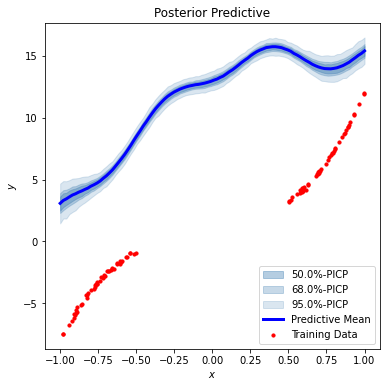

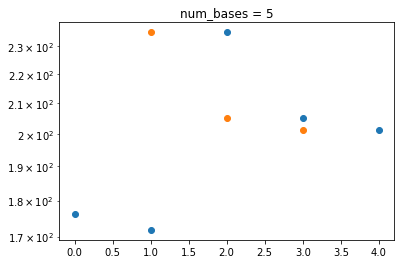

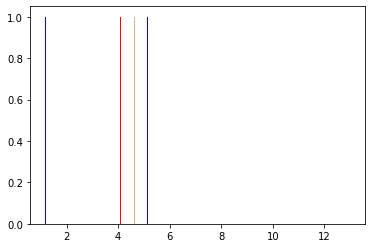

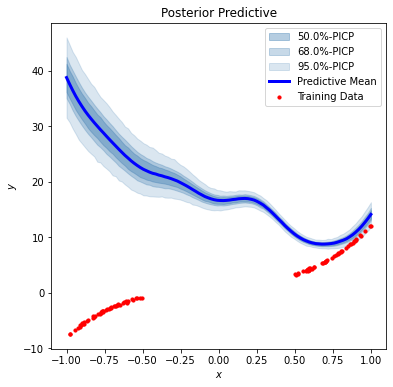

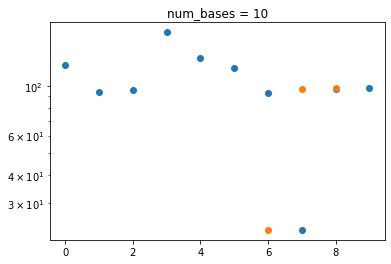

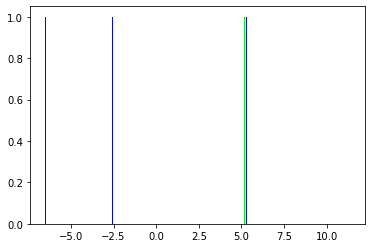

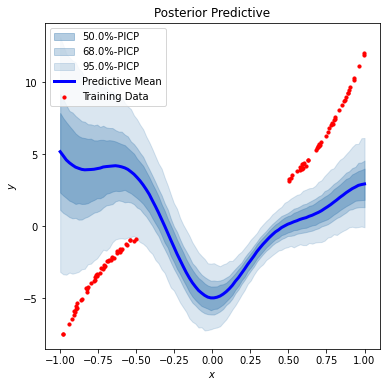

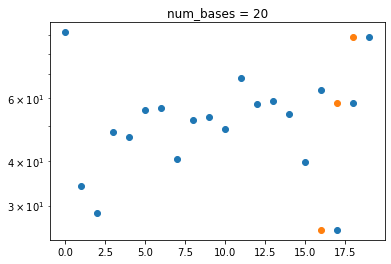

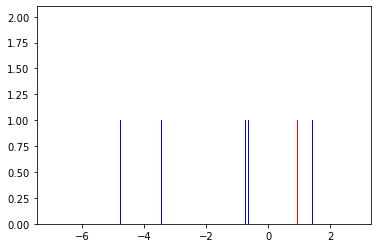

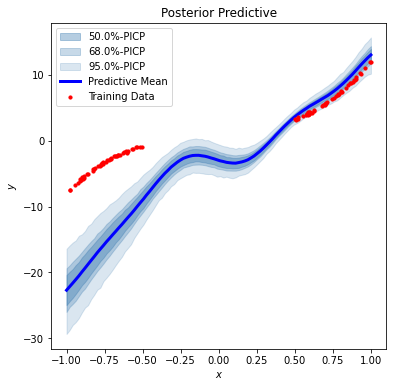

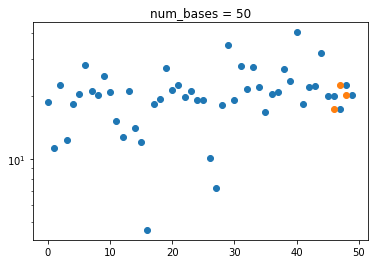

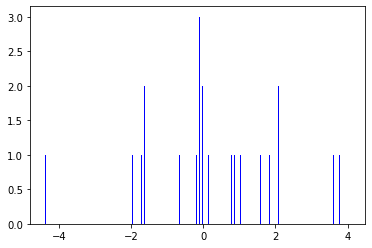

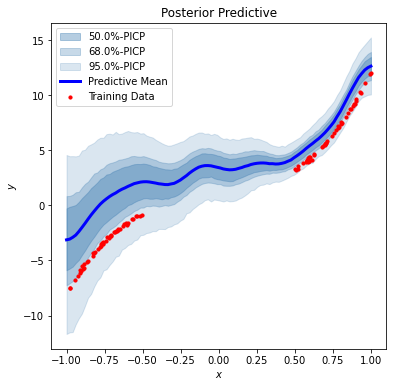

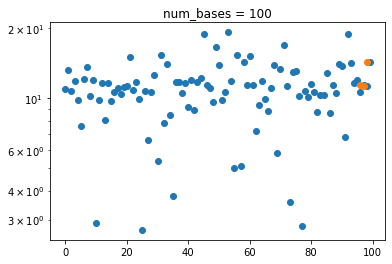

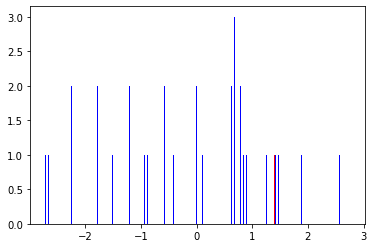

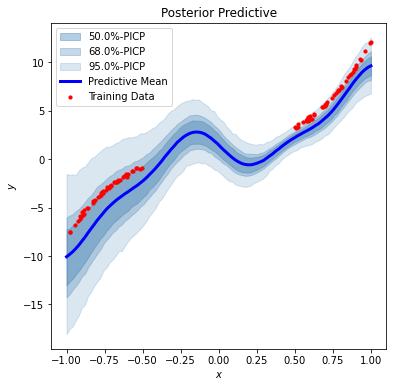

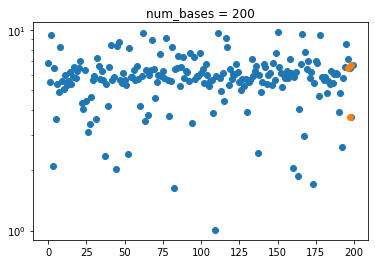

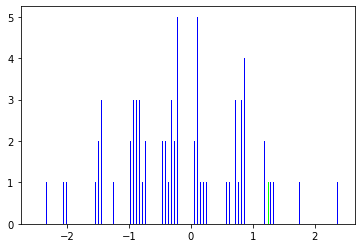

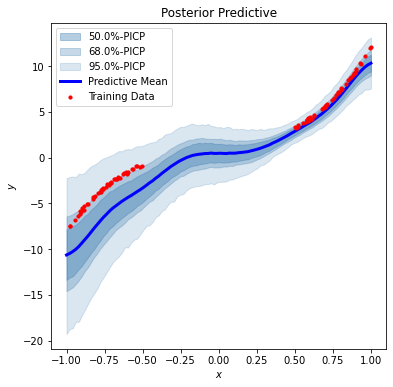

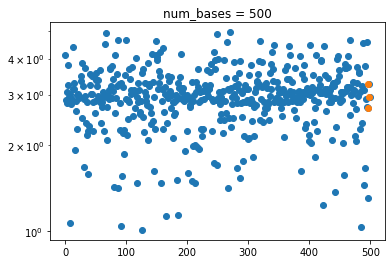

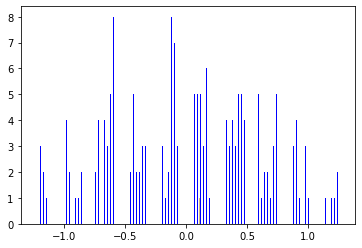

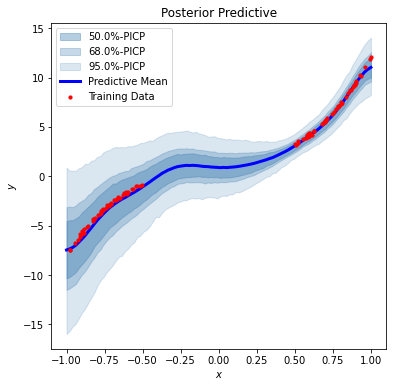

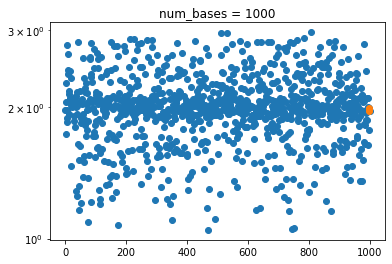

ValueError: x and y must have same first dimension, but have shapes (8,) and (3,)

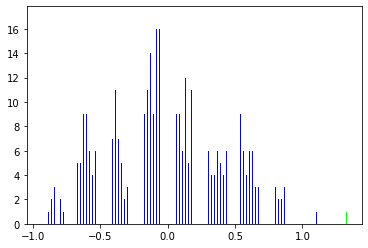

In [37]:
# An example with bad data fit
teacher_1 = lambda x: (x)**3
teacher_2 = lambda x: (x-1)**2
teacher_3 = lambda x: x # third cos teacher 
teacher = lambda x: 8*teacher_1(x) + 1*teacher_2(x) + 4*teacher_3(x) # weighted sum of the two
num_bases = 100

x, y = generate_data(teacher, 100, dataset_min_range=-1, dataset_max_range=1, gap_min_range=-0.5, gap_max_range=0.5)

posterior_of_teacher = []
true_bases = True

for num_bases in [5, 10, 20, 50, 100, 200, 500, 1000]:
    rff_basis = create_fourier_basis(num_bases, omega_scale=5)
    phi = rff_basis(x)

    blm = BayesianRegression(w_prior_var=1, output_var=.1)
    blm.infer_posterior(phi, y).loc

    x_viz = torch.linspace(-1, 1, 100)
    phi_t = rff_basis(x_viz)
    if true_bases:
        phi_t[:,-3] = teacher_1(x_viz).squeeze()
        phi_t[:,-2] = teacher_2(x_viz).squeeze()
        phi_t[:,-1] = teacher_3(x_viz).squeeze()

    blm.visualize_posterior_predictive(x_viz, phi_t, x, y)
    posterior_of_teacher.append(blm.posterior.loc[-4:-1].numpy())
    plt.plot(np.arange(0, num_bases), np.diag(blm.posterior.precision_matrix)[:-1], 'o')
    plt.title("num_bases = {}".format(num_bases))
    if true_bases:
        plt.plot(np.arange(num_bases-4, num_bases-1), np.diag(blm.posterior.precision_matrix)[-4:-1], 'o')
    plt.yscale('log')
    plt.show()
    #plt.hist(blm.posterior.loc.numpy(), 100)
    fig, ax = plt.subplots()
    colors = ['blue','red', 'tan', 'lime']
    post_multi = [blm.posterior.loc.numpy()[:-3],blm.posterior.loc.numpy()[-3:-2],blm.posterior.loc.numpy()[-2:-1],blm.posterior.loc.numpy()[-1]]
    ax.hist(post_multi, 200, histtype='bar', color = colors, label = ["all","teacher1","teacher2","teacher3"])

plt.plot([5, 10, 20, 50, 100, 200, 500, 1000], np.array(posterior_of_teacher)[0])


#### previous experiments

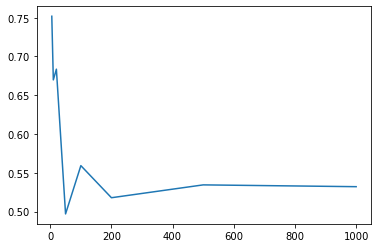

In [ ]:
plt.plot([5, 10, 20, 50, 100, 200, 500, 1000], np.array(posterior_of_teacher)[:,0])

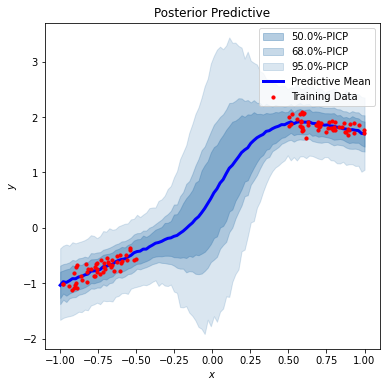

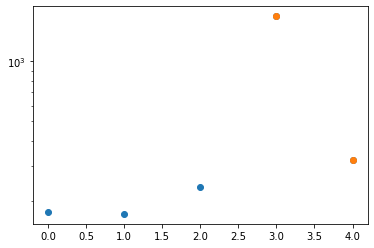

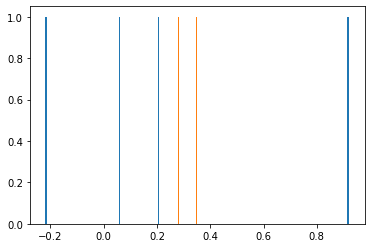

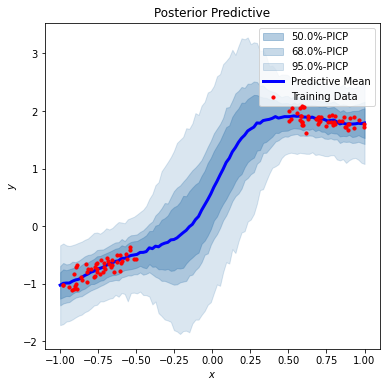

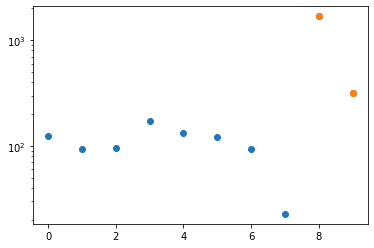

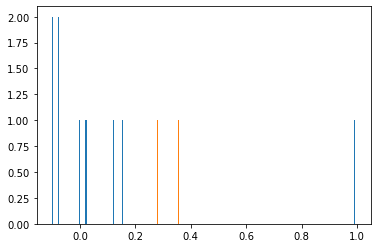

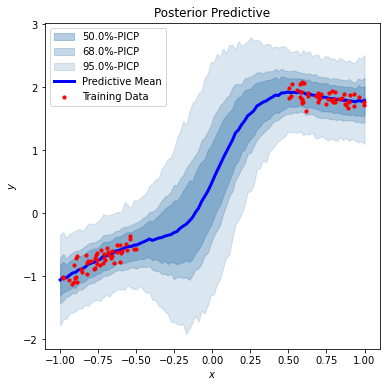

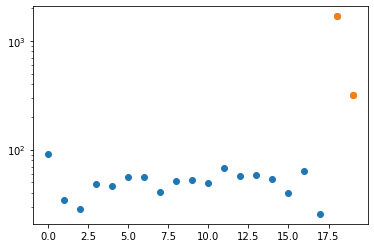

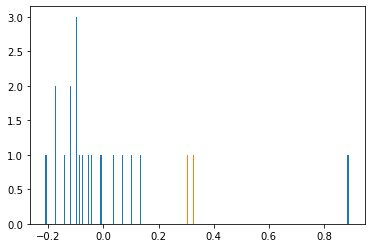

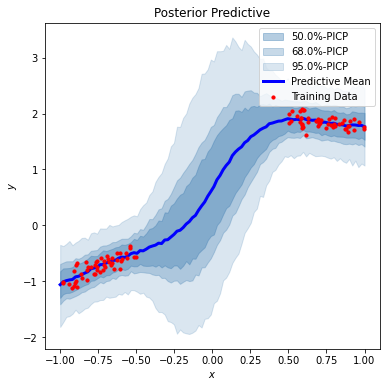

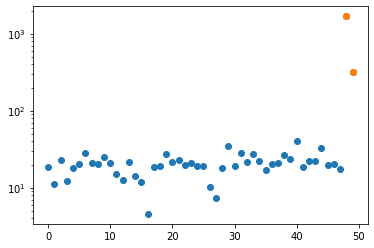

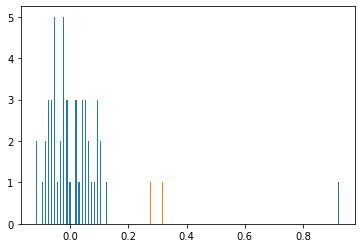

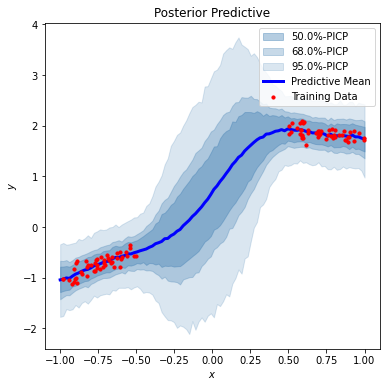

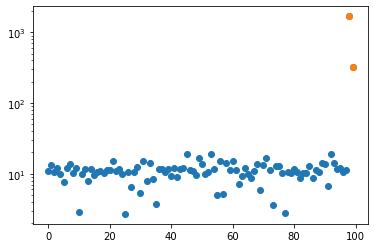

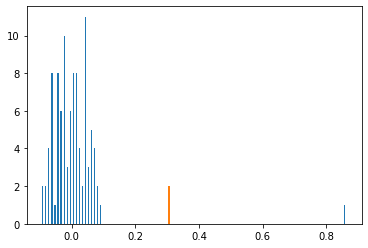

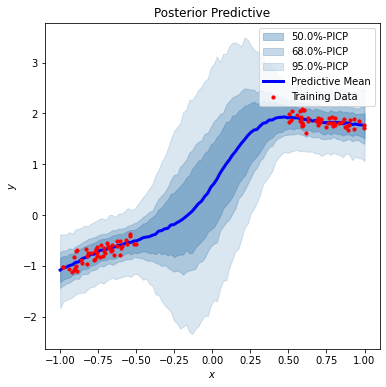

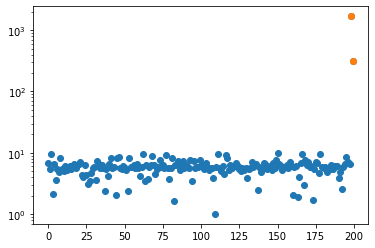

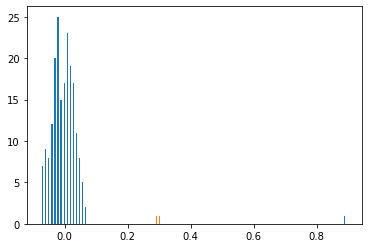

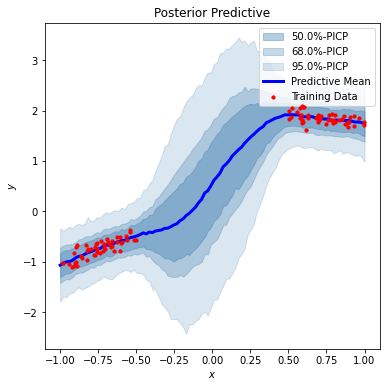

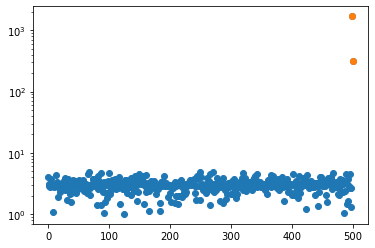

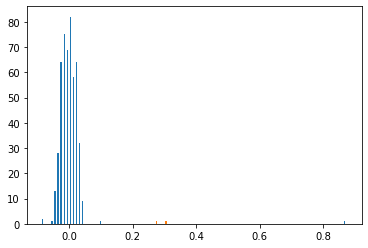

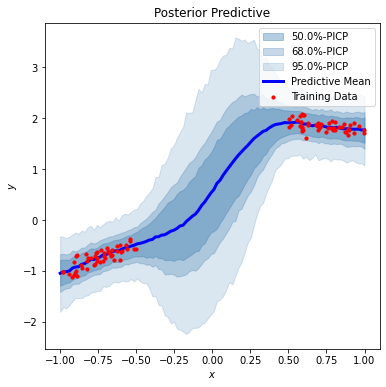

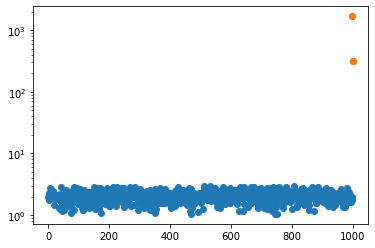

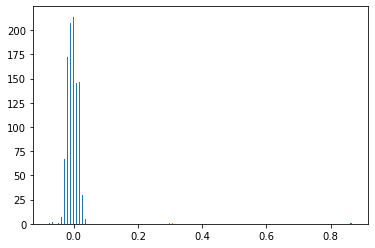

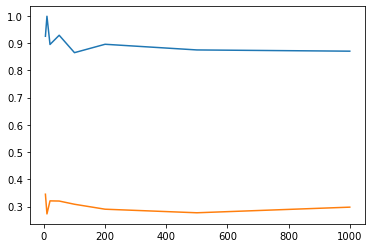

In [33]:
teacher_1 = lambda x: torch.atan(5*x)
teacher_2 = lambda x: np.cos(x)**2
teacher = lambda x: teacher_1(x) + teacher_2(x)
num_bases = 100

x, y = generate_data(teacher, 100, dataset_min_range=-1, dataset_max_range=1, gap_min_range=-0.5, gap_max_range=0.5)

posterior_of_teacher = []
true_bases = True

for num_bases in [5, 10, 20, 50, 100, 200, 500, 1000]:
    rff_basis = create_fourier_basis(num_bases, omega_scale=5)
    phi = rff_basis(x)

    if true_bases:
        phi[:,-2] = teacher_1(x).squeeze()
        phi[:,-1] = teacher_2(x).squeeze()

    blm = BayesianRegression(w_prior_var=1, output_var=.1)
    blm.infer_posterior(phi, y).loc

    x_viz = torch.linspace(-1, 1, 100)
    phi_t = rff_basis(x_viz)
    if true_bases:
        phi_t[:,-2] = teacher_1(x_viz).squeeze()
        phi_t[:,-1] = teacher_2(x_viz).squeeze()


    blm.visualize_posterior_predictive(x_viz, phi_t, x, y)
    posterior_of_teacher.append(blm.posterior.loc[-3:-1].numpy())
    plt.plot(np.arange(0, num_bases), np.diag(blm.posterior.precision_matrix)[:-1], 'o')
    if true_bases:
        plt.plot(np.arange(num_bases-2, num_bases), np.diag(blm.posterior.precision_matrix)[-3:-1], 'o')
    plt.yscale('log')
    plt.show()
    fig, ax = plt.subplots()
    post_multi = [blm.posterior.loc.numpy()[:-2],blm.posterior.loc.numpy()[-2:]]
    ax.hist(post_multi, 100, histtype='bar')
    plt.show()

plt.plot([5, 10, 20, 50, 100, 200, 500, 1000], np.array(posterior_of_teacher))


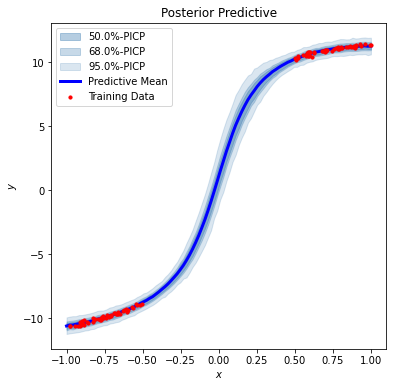

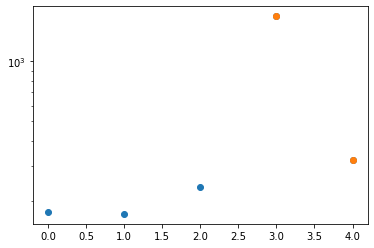

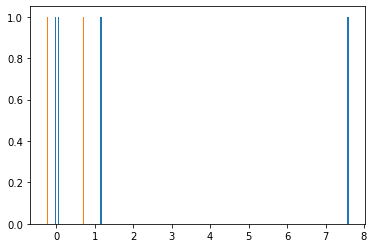

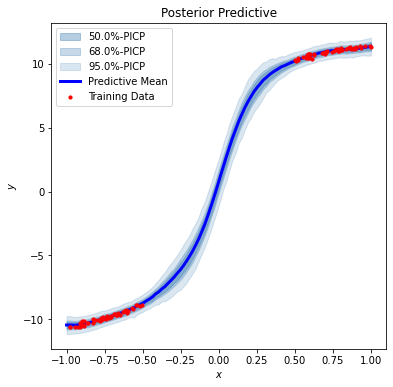

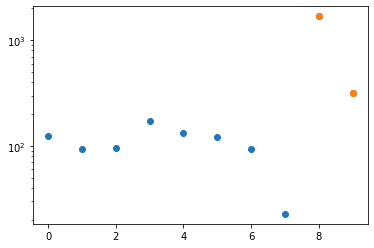

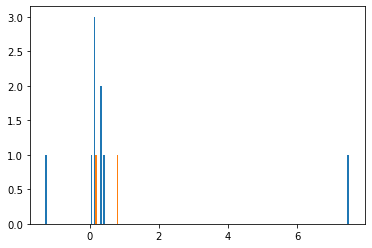

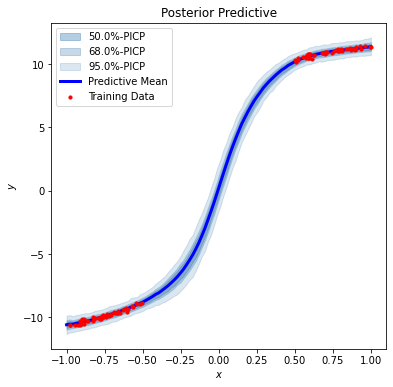

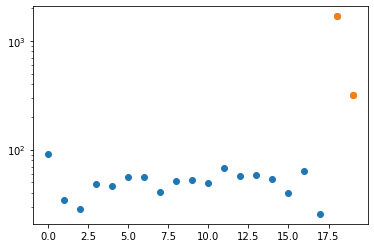

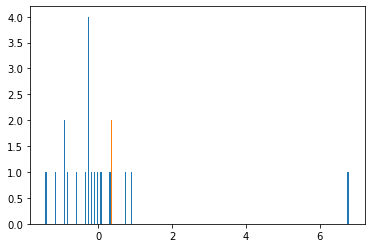

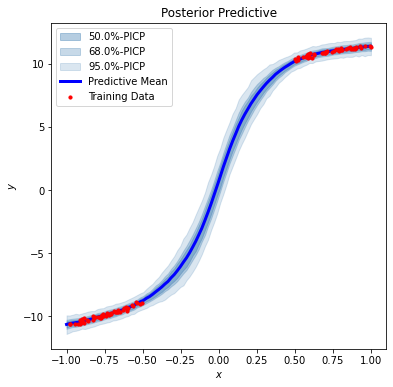

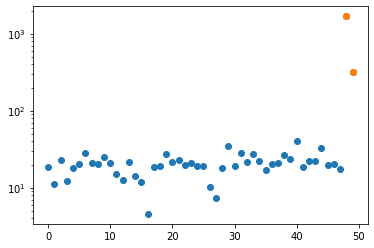

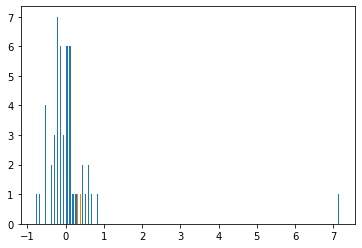

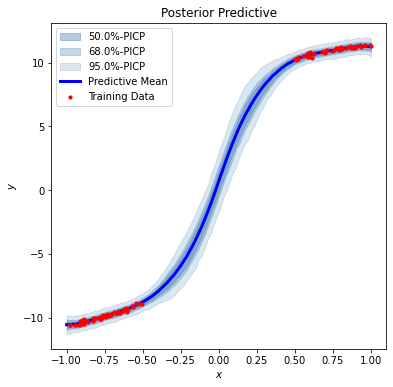

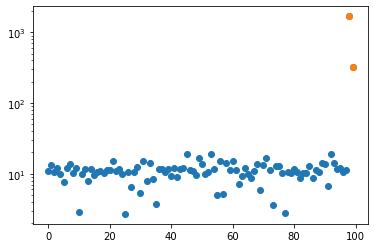

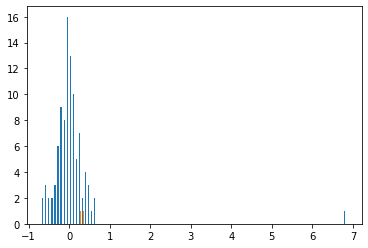

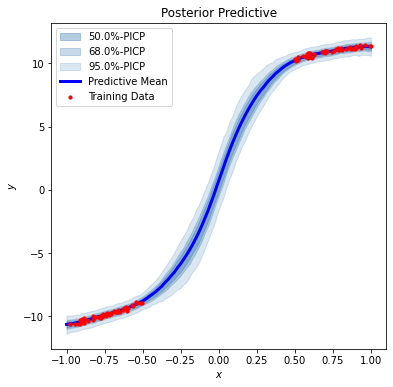

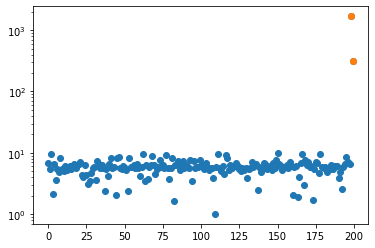

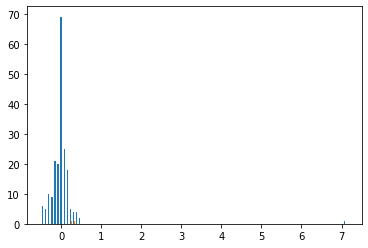

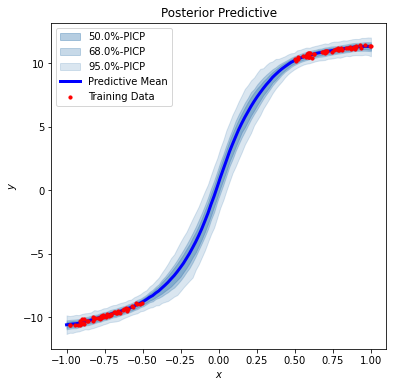

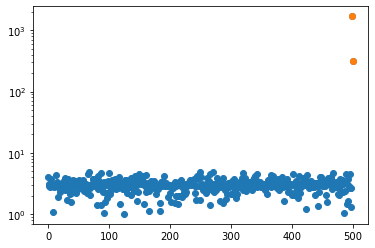

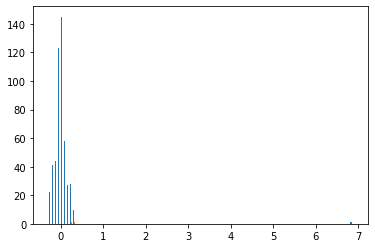

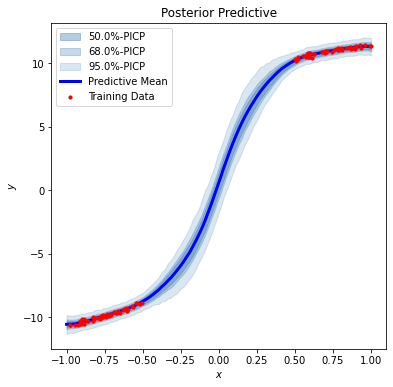

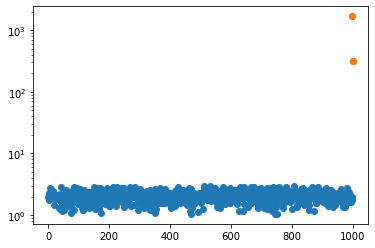

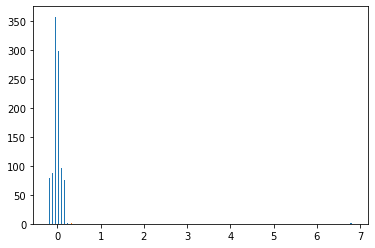

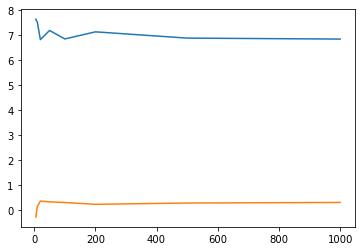

In [34]:
teacher_1 = lambda x: torch.atan(5*x)
teacher_2 = lambda x: torch.cos(x)**2
teacher = lambda x: 8*teacher_1(x) + teacher_2(x)
num_bases = 100

x, y = generate_data(teacher, 100, dataset_min_range=-1, dataset_max_range=1, gap_min_range=-0.5, gap_max_range=0.5)

posterior_of_teacher = []
true_bases = True

for num_bases in [5, 10, 20, 50, 100, 200, 500, 1000]:
    rff_basis = create_fourier_basis(num_bases, omega_scale=5)
    phi = rff_basis(x)

    if true_bases:
        phi[:,-2] = teacher_1(x).squeeze()
        phi[:,-1] = teacher_2(x).squeeze()

    blm = BayesianRegression(w_prior_var=1, output_var=.1)
    blm.infer_posterior(phi, y).loc

    x_viz = torch.linspace(-1, 1, 100)
    phi_t = rff_basis(x_viz)
    if true_bases:
        phi_t[:,-2] = teacher_1(x_viz).squeeze()
        phi_t[:,-1] = teacher_2(x_viz).squeeze()


    blm.visualize_posterior_predictive(x_viz, phi_t, x, y)
    posterior_of_teacher.append(blm.posterior.loc[-3:-1].numpy())
    plt.plot(np.arange(0, num_bases), np.diag(blm.posterior.precision_matrix)[:-1], 'o')
    if true_bases:
        plt.plot(np.arange(num_bases-2, num_bases), np.diag(blm.posterior.precision_matrix)[-3:-1], 'o')
    plt.yscale('log')
    plt.show()
    #plt.hist(blm.posterior.loc.numpy(), 100)
    fig, ax = plt.subplots()
    post_multi = [blm.posterior.loc.numpy()[:-2],blm.posterior.loc.numpy()[-2:]]
    ax.hist(post_multi, 100, histtype='bar')

    plt.show()

plt.plot([5, 10, 20, 50, 100, 200, 500, 1000], np.array(posterior_of_teacher))


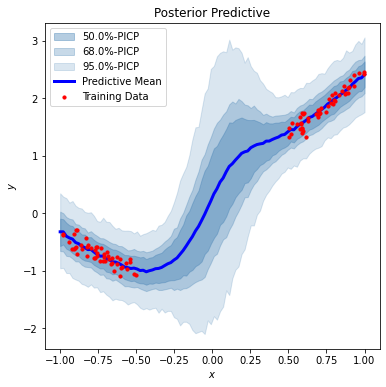

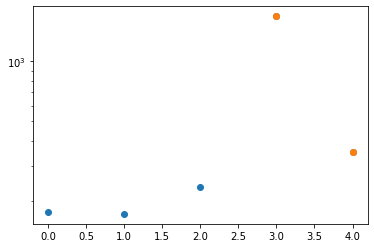

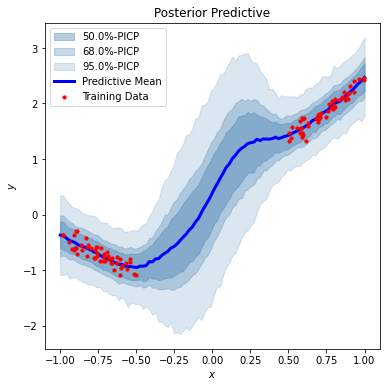

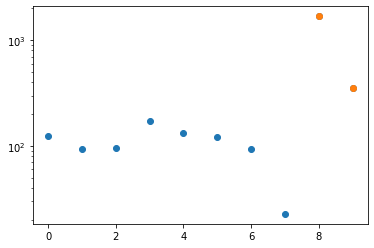

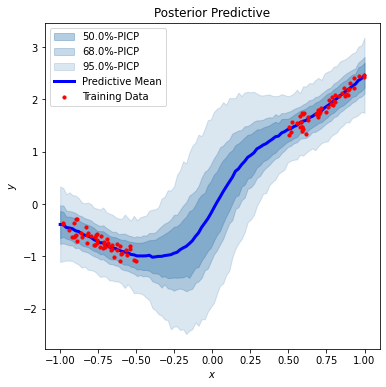

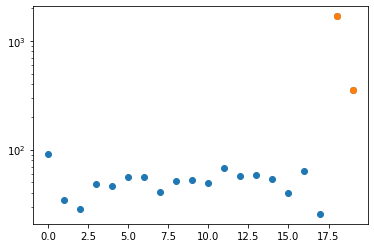

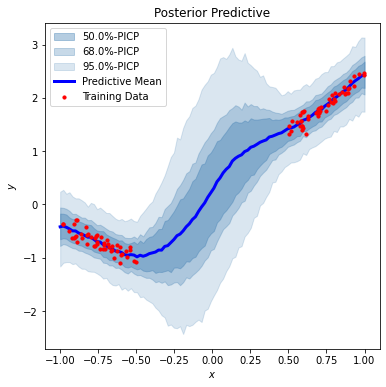

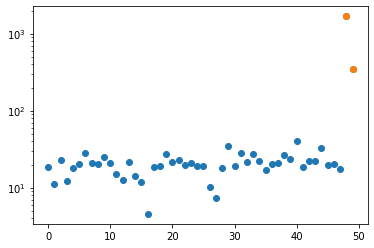

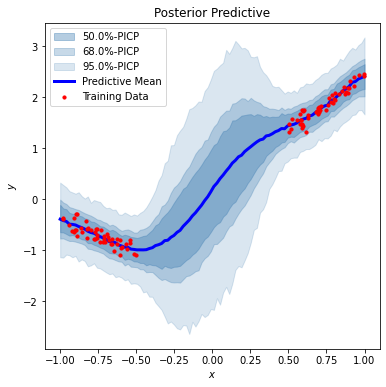

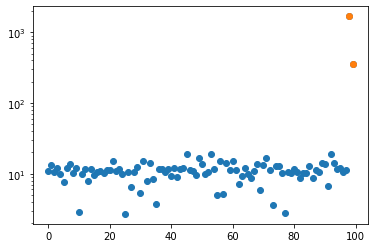

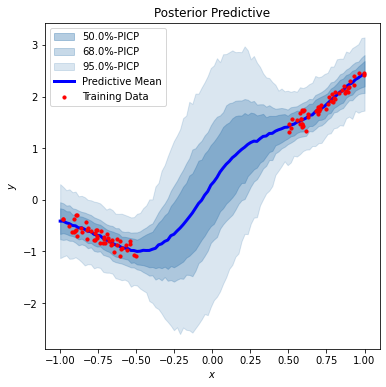

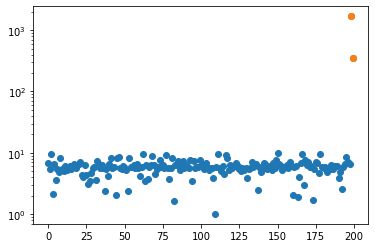

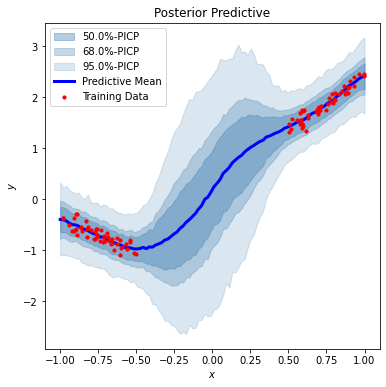

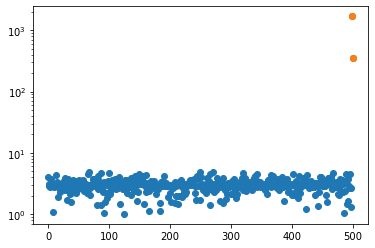

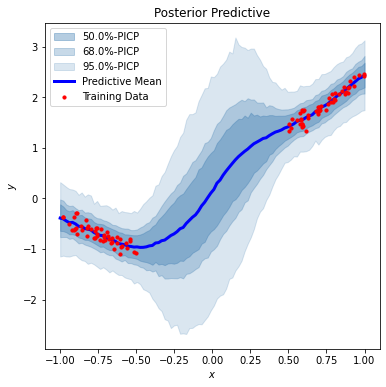

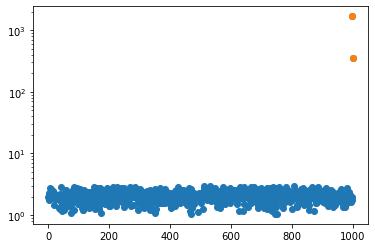

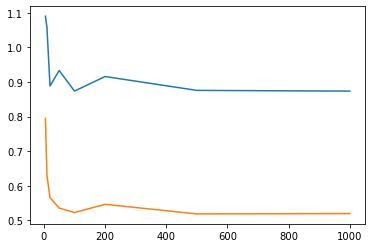

In [32]:
teacher_1 = lambda x: torch.atan(5*x)
teacher_2 = lambda x: x**2
teacher = lambda x: teacher_1(x) + teacher_2(x)
num_bases = 100

x, y = generate_data(teacher, 100, dataset_min_range=-1, dataset_max_range=1, gap_min_range=-0.5, gap_max_range=0.5)

posterior_of_teacher = []
true_bases = True

for num_bases in [5, 10, 20, 50, 100, 200, 500, 1000]:
    rff_basis = create_fourier_basis(num_bases, omega_scale=5)
    phi = rff_basis(x)

    if true_bases:
        phi[:,-2] = teacher_1(x).squeeze()
        phi[:,-1] = teacher_2(x).squeeze()

    blm = BayesianRegression(w_prior_var=1, output_var=.1)
    blm.infer_posterior(phi, y).loc

    x_viz = torch.linspace(-1, 1, 100)
    phi_t = rff_basis(x_viz)
    if true_bases:
        phi_t[:,-2] = teacher_1(x_viz).squeeze()
        phi_t[:,-1] = teacher_2(x_viz).squeeze()


    blm.visualize_posterior_predictive(x_viz, phi_t, x, y)
    posterior_of_teacher.append(blm.posterior.loc[-3:-1].numpy())
    plt.plot(np.arange(0, num_bases), np.diag(blm.posterior.precision_matrix)[:-1], 'o')
    if true_bases:
        plt.plot(np.arange(num_bases-2, num_bases), np.diag(blm.posterior.precision_matrix)[-3:-1], 'o')
    plt.yscale('log')
    plt.show()

plt.plot([5, 10, 20, 50, 100, 200, 500, 1000], np.array(posterior_of_teacher))


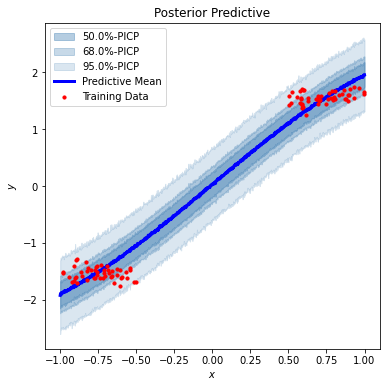

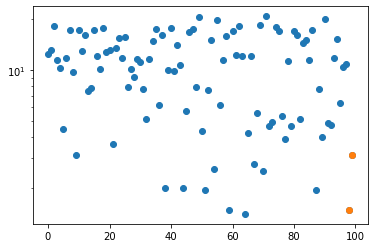

In [316]:
teacher_1 = lambda x: torch.atan(x*100)
teacher_2 = lambda x: x * 0
teacher = lambda x: teacher_1(x) + teacher_2(x)
num_bases = 100

x, y = generate_data(teacher, 100, dataset_min_range=-1, dataset_max_range=1, gap_min_range=-0.5, gap_max_range=0.5)

rff_basis = create_fourier_basis(num_bases, omega_scale=0.5)
phi = rff_basis(x)
# phi[:,-1:] = teacher(x)
# phi[:,-2] = teacher_1(x).squeeze()
# phi[:,-1] = teacher_2(x).squeeze()

blm = BayesianRegression(w_prior_var=1, output_var=.1)
blm.infer_posterior(phi, y).loc

x_viz = torch.linspace(-1, 1, 1000)
phi_t = rff_basis(x_viz)
# phi_t[:,-2] = teacher_1(x_viz).squeeze()
# phi_t[:,-1] = teacher_2(x_viz).squeeze()

# phi_t = torch.hstack((phi_t, torch.ones((100, 1))))
blm.visualize_posterior_predictive(x_viz, phi_t, x, y)
blm.posterior.loc[-3:-1]
plt.plot(np.arange(0, num_bases), np.diag(blm.posterior.precision_matrix)[:-1], 'o')
plt.plot(np.arange(num_bases-2, num_bases), np.diag(blm.posterior.precision_matrix)[-3:-1], 'o')
plt.yscale('log')
plt.show()


In [ ]:
teacher_1 = lambda x: torch.atan(5*x)
teacher_2 = lambda x: torch.cos(2*x)**2
teacher = lambda x: teacher_1(x) + teacher_2(x)
num_bases = 100

x, y = generate_data(teacher, 100, dataset_min_range=-1, dataset_max_range=1, gap_min_range=-0.5, gap_max_range=0.5)

posterior_of_teacher = []
true_bases = True

for num_bases in [5, 10, 20, 50, 100, 200, 500, 1000]:
    rff_basis = create_fourier_basis(num_bases, omega_scale=5)
    phi = rff_basis(x)

    if true_bases:
        phi[:,-2] = teacher_1(x).squeeze()
        phi[:,-1] = teacher_2(x).squeeze()

    blm = BayesianRegression(w_prior_var=1, output_var=.1)
    blm.infer_posterior(phi, y).loc

    x_viz = torch.linspace(-1, 1, 100)
    phi_t = rff_basis(x_viz)
    if true_bases:
        phi_t[:,-2] = teacher_1(x_viz).squeeze()
        phi_t[:,-1] = teacher_2(x_viz).squeeze()


    blm.visualize_posterior_predictive(x_viz, phi_t, x, y)
    posterior_of_teacher.append(blm.posterior.loc[-3:-1].numpy())
    plt.plot(np.arange(0, num_bases), np.diag(blm.posterior.precision_matrix)[:-1], 'o')
    if true_bases:
        plt.plot(np.arange(num_bases-2, num_bases), np.diag(blm.posterior.precision_matrix)[-3:-1], 'o')
    plt.yscale('log')
    plt.show()

plt.plot([5, 10, 20, 50, 100, 200, 500, 1000], np.array(posterior_of_teacher))


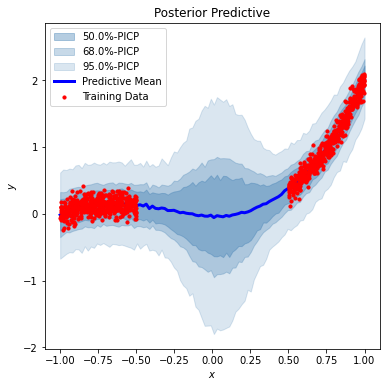

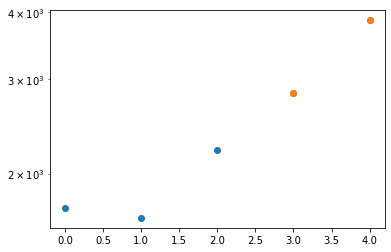

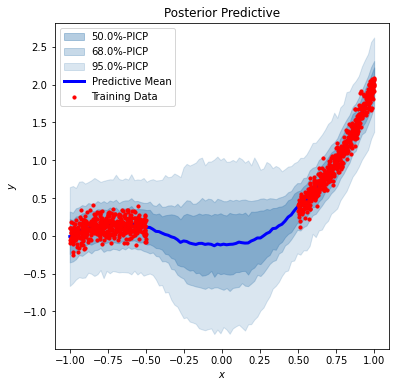

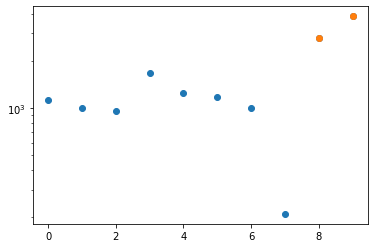

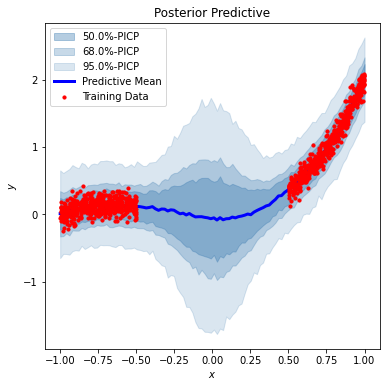

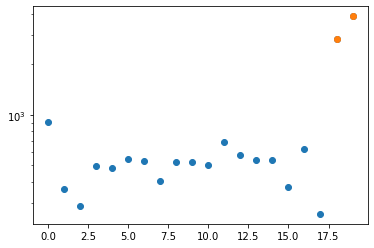

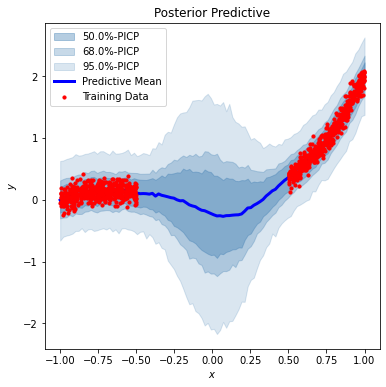

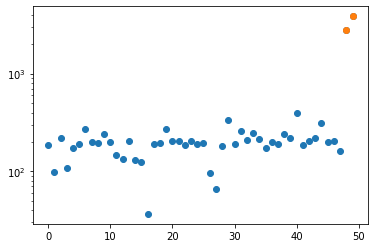

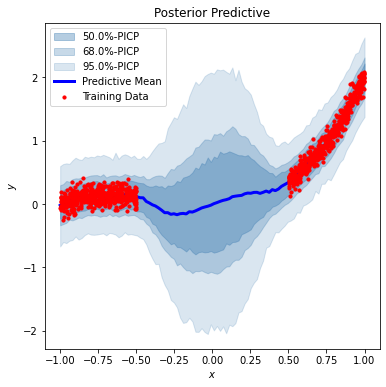

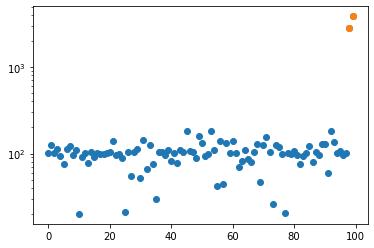

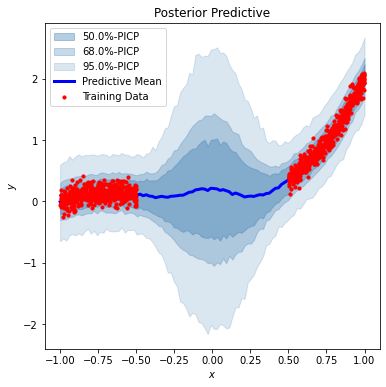

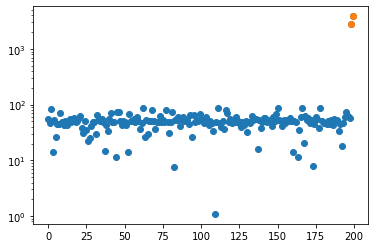

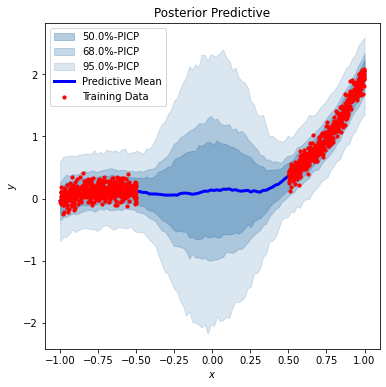

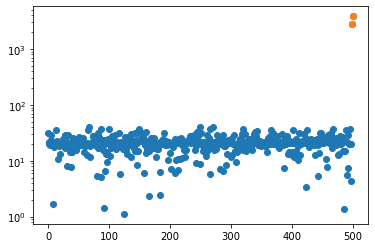

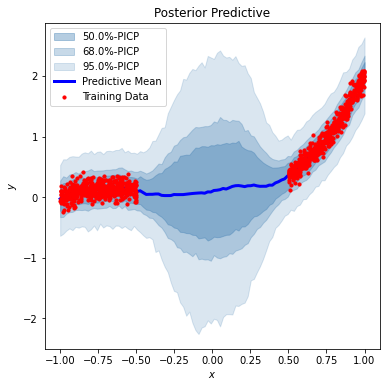

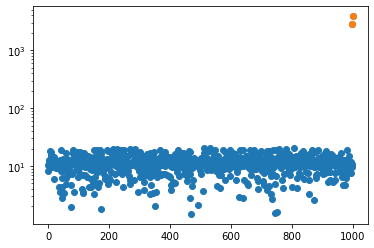

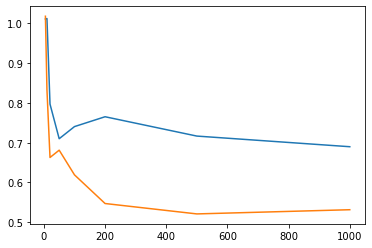

In [47]:
teacher_1 = lambda x: x**3
teacher_2 = lambda x: x**2
teacher = lambda x: teacher_1(x) + teacher_2(x)
num_bases = 100

posterior_of_teacher = []
true_bases = True

x, y = generate_data(teacher, 1000, dataset_min_range=-1, dataset_max_range=1, gap_min_range=-0.5, gap_max_range=0.5)

for num_bases in [5, 10, 20, 50, 100, 200, 500, 1000]:
    rff_basis = create_fourier_basis(num_bases, omega_scale=5)
    phi = rff_basis(x)

    if true_bases:
        phi[:,-2] = teacher_1(x).squeeze()
        phi[:,-1] = teacher_2(x).squeeze()

    blm = BayesianRegression(w_prior_var=1, output_var=.1)
    blm.infer_posterior(phi, y).loc

    x_viz = torch.linspace(-1, 1, 100)
    phi_t = rff_basis(x_viz)
    if true_bases:
        phi_t[:,-2] = teacher_1(x_viz).squeeze()
        phi_t[:,-1] = teacher_2(x_viz).squeeze()


    blm.visualize_posterior_predictive(x_viz, phi_t, x, y)
    posterior_of_teacher.append(blm.posterior.loc[-3:-1].numpy())
    plt.plot(np.arange(0, num_bases), np.diag(blm.posterior.precision_matrix)[:-1], 'o')
    if true_bases:
        plt.plot(np.arange(num_bases-2, num_bases), np.diag(blm.posterior.precision_matrix)[-3:-1], 'o')
    plt.yscale('log')
    plt.show()

plt.plot([5, 10, 20, 50, 100, 200, 500, 1000], np.array(posterior_of_teacher))


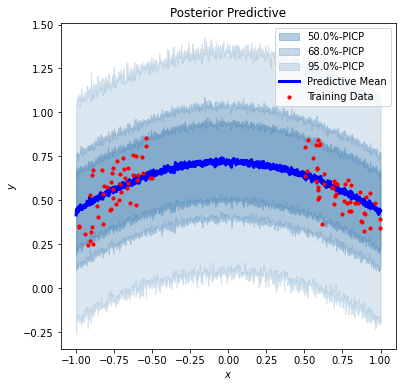

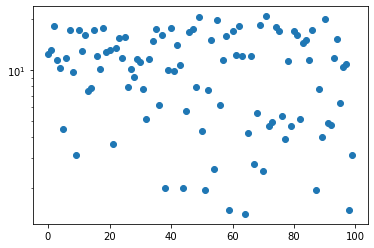

In [278]:
teacher_1 = lambda x: torch.cos(x)**2
teacher_2 = lambda x: x * 0
teacher = lambda x: teacher_1(x) + teacher_2(x)

true_bases = False

num_bases = 100

x, y = generate_data(teacher, 100, dataset_min_range=-1, dataset_max_range=1, gap_min_range=-0.5, gap_max_range=0.5)
rff_basis = create_fourier_basis(num_bases, omega_scale=0.5)
phi = rff_basis(x)
# phi[:,-1:] = teacher(x)
if true_bases:
    phi[:,-2] = teacher_1(x).squeeze()
    phi[:,-1] = teacher_2(x).squeeze()

blm = BayesianRegression(w_prior_var=1, output_var=.1)
blm.infer_posterior(phi, y).loc

x_viz = torch.linspace(-1, 1, 1000)
phi_t = rff_basis(x_viz)
if true_bases:
    phi_t[:,-2] = teacher_1(x_viz).squeeze()
    phi_t[:,-1] = teacher_2(x_viz).squeeze()

# phi_t = torch.hstack((phi_t, torch.ones((100, 1))))
blm.visualize_posterior_predictive(x_viz, phi_t, x, y)
blm.posterior.loc[-3:-1]
plt.plot(np.arange(0, num_bases), np.diag(blm.posterior.precision_matrix)[:-1], 'o')
if true_bases:
    plt.plot(np.arange(num_bases-2, num_bases), np.diag(blm.posterior.precision_matrix)[-3:-1], 'o')
plt.yscale('log')
plt.show()


In [319]:
posterior_of_teacher

[array([ 1.38576262, -0.68150033]),
 array([ 1.28399227, -0.23426303]),
 array([1.06580821, 0.05949351]),
 array([ 1.10031984, -0.03032335]),
 array([0.9791388, 0.0731035]),
 array([ 1.11924905, -0.03810043]),
 array([0.85334068, 0.01460887]),
 array([1.11613955, 0.11724674]),
 array([ 1.08817723, -0.00380926]),
 array([1.18531158, 0.00694567])]